# Loop 2 Analysis: Overlapping Trees Issue

The submission failed with 'Overlapping trees in group 002'. Need to:
1. Understand why overlaps occurred
2. Add overlap checking to our ensemble code
3. Find valid configurations only

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity

# Tree polygon vertices
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]
BASE_TREE = Polygon(zip(TX, TY))

def parse_value(val):
    if isinstance(val, str):
        if val.startswith('s'):
            return float(val[1:])
        return float(val)
    return float(val)

def create_tree(x, y, deg):
    tree = affinity.rotate(BASE_TREE, deg, origin=(0, 0))
    tree = affinity.translate(tree, x, y)
    return tree

def check_overlap(tree1, tree2):
    """Check if two trees overlap (interior intersection)"""
    return tree1.intersects(tree2) and not tree1.touches(tree2)

def check_group_overlaps(df, n):
    """Check if any trees in group N overlap"""
    prefix = f"{n:03d}_"
    n_rows = df[df['id'].str.startswith(prefix)]
    
    trees = []
    for _, row in n_rows.iterrows():
        x = parse_value(row['x'])
        y = parse_value(row['y'])
        deg = parse_value(row['deg'])
        trees.append(create_tree(x, y, deg))
    
    # Check all pairs
    for i in range(len(trees)):
        for j in range(i+1, len(trees)):
            if check_overlap(trees[i], trees[j]):
                return True, (i, j)
    return False, None

print("Functions defined")

Functions defined


In [2]:
# Load the failed submission
df = pd.read_csv('/home/submission/submission.csv')
print(f"Loaded {len(df)} rows")

# Check group 002 specifically
has_overlap, pair = check_group_overlaps(df, 2)
print(f"Group 002 has overlap: {has_overlap}, pair: {pair}")

# Show the trees in group 002
group_002 = df[df['id'].str.startswith('002_')]
print("\nGroup 002 trees:")
print(group_002)

Loaded 20100 rows
Group 002 has overlap: True, pair: (0, 1)

Group 002 trees:
      id                       x                       y  \
1  002_0   s0.154097069621355887  s-0.038540742694794648   
2  002_1  s-0.154097069621372845  s-0.561459257305224058   

                       deg  
1  s144.272760863123583164  
2  s324.272760863123533426  


In [3]:
# Check all groups for overlaps
overlapping_groups = []
for n in range(1, 201):
    has_overlap, pair = check_group_overlaps(df, n)
    if has_overlap:
        overlapping_groups.append((n, pair))
        if len(overlapping_groups) <= 10:
            print(f"Group {n:03d} has overlap between trees {pair}")

print(f"\nTotal groups with overlaps: {len(overlapping_groups)}")
if len(overlapping_groups) > 10:
    print(f"First 10: {overlapping_groups[:10]}")
    print(f"Last 10: {overlapping_groups[-10:]}")
else:
    print(f"All overlapping groups: {overlapping_groups}")

Group 002 has overlap between trees (0, 1)
Group 004 has overlap between trees (0, 1)
Group 005 has overlap between trees (0, 1)
Group 008 has overlap between trees (2, 6)
Group 011 has overlap between trees (3, 5)
Group 016 has overlap between trees (0, 3)
Group 017 has overlap between trees (2, 15)
Group 021 has overlap between trees (13, 15)
Group 026 has overlap between trees (5, 22)
Group 027 has overlap between trees (10, 25)



Total groups with overlaps: 80
First 10: [(2, (0, 1)), (4, (0, 1)), (5, (0, 1)), (8, (2, 6)), (11, (3, 5)), (16, (0, 3)), (17, (2, 15)), (21, (13, 15)), (26, (5, 22)), (27, (10, 25))]
Last 10: [(168, (0, 5)), (175, (0, 33)), (176, (1, 39)), (177, (1, 39)), (178, (1, 39)), (179, (1, 39)), (185, (0, 32)), (190, (0, 12)), (191, (0, 22)), (192, (0, 22))]


In [4]:
# Let's check which snapshot the N=2 came from and if it has overlaps
from pathlib import Path

# According to the log, N=2 came from 21145966992
snapshot_path = Path('/home/nonroot/snapshots/santa-2025/21145966992/submission/submission.csv')
df_snapshot = pd.read_csv(snapshot_path)

has_overlap, pair = check_group_overlaps(df_snapshot, 2)
print(f"Snapshot 21145966992 group 002 has overlap: {has_overlap}")

# Show the trees
group_002_snap = df_snapshot[df_snapshot['id'].str.startswith('002_')]
print("\nSnapshot group 002 trees:")
print(group_002_snap)

Snapshot 21145966992 group 002 has overlap: True

Snapshot group 002 trees:
      id                       x                       y  \
1  002_0   s0.154097069621355887  s-0.038540742694794648   
2  002_1  s-0.154097069621372845  s-0.561459257305224058   

                       deg  
1  s144.272760863123583164  
2  s324.272760863123533426  


In [5]:
# Compare the two - maybe the 's' prefix conversion is causing issues?
# Let's check if the values are the same

print("Ensemble submission values:")
for _, row in group_002.iterrows():
    print(f"  {row['id']}: x={parse_value(row['x']):.15f}, y={parse_value(row['y']):.15f}, deg={parse_value(row['deg']):.15f}")

print("\nSnapshot values:")
for _, row in group_002_snap.iterrows():
    print(f"  {row['id']}: x={parse_value(row['x']):.15f}, y={parse_value(row['y']):.15f}, deg={parse_value(row['deg']):.15f}")

Ensemble submission values:
  002_0: x=0.154097069621356, y=-0.038540742694795, deg=144.272760863123580
  002_1: x=-0.154097069621373, y=-0.561459257305224, deg=324.272760863123551

Snapshot values:
  002_0: x=0.154097069621356, y=-0.038540742694795, deg=144.272760863123580
  002_1: x=-0.154097069621373, y=-0.561459257305224, deg=324.272760863123551


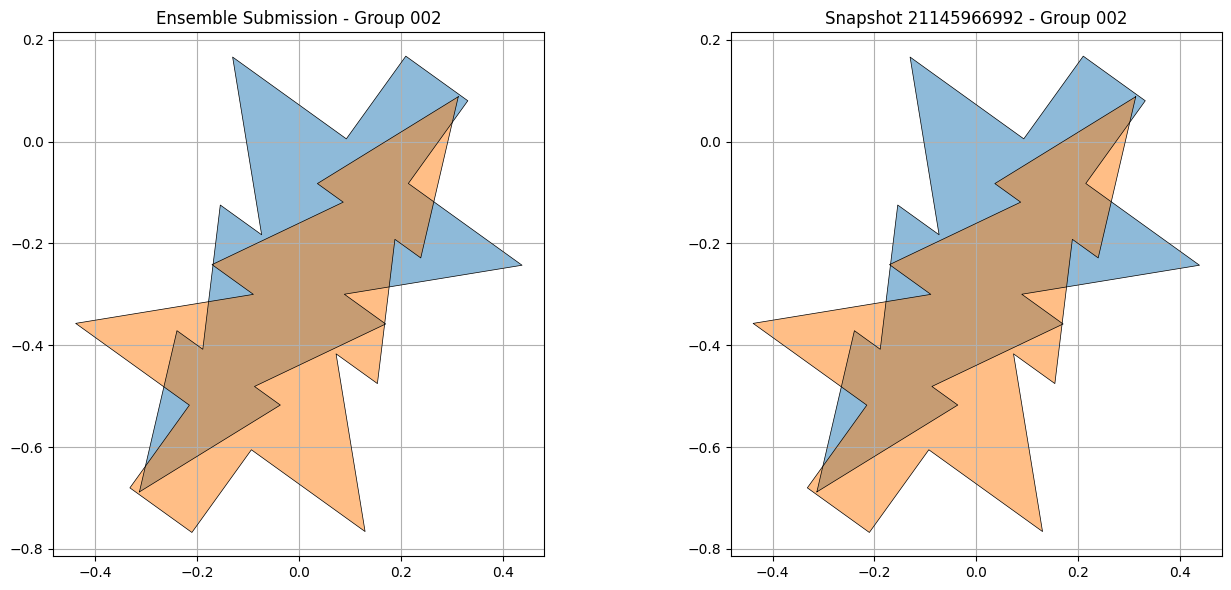

Saved visualization


In [6]:
# Visualize the overlap
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot ensemble submission
ax = axes[0]
ax.set_title('Ensemble Submission - Group 002')
for _, row in group_002.iterrows():
    x = parse_value(row['x'])
    y = parse_value(row['y'])
    deg = parse_value(row['deg'])
    tree = create_tree(x, y, deg)
    xs, ys = tree.exterior.xy
    ax.fill(xs, ys, alpha=0.5)
    ax.plot(xs, ys, 'k-', linewidth=0.5)
ax.set_aspect('equal')
ax.grid(True)

# Plot snapshot
ax = axes[1]
ax.set_title('Snapshot 21145966992 - Group 002')
for _, row in group_002_snap.iterrows():
    x = parse_value(row['x'])
    y = parse_value(row['y'])
    deg = parse_value(row['deg'])
    tree = create_tree(x, y, deg)
    xs, ys = tree.exterior.xy
    ax.fill(xs, ys, alpha=0.5)
    ax.plot(xs, ys, 'k-', linewidth=0.5)
ax.set_aspect('equal')
ax.grid(True)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop2_overlap_analysis.png', dpi=100)
plt.show()
print("Saved visualization")

In [7]:
# Check if the snapshot itself has overlaps
print("Checking all snapshots for overlaps in group 002...")

snapshot_dir = Path('/home/nonroot/snapshots/santa-2025')
for snapshot_path in sorted(snapshot_dir.iterdir())[:10]:  # Check first 10
    if snapshot_path.is_dir():
        submission_path = snapshot_path / 'submission' / 'submission.csv'
        if submission_path.exists():
            try:
                df_snap = pd.read_csv(submission_path)
                has_overlap, pair = check_group_overlaps(df_snap, 2)
                if has_overlap:
                    print(f"{snapshot_path.name}: OVERLAP in group 002")
                else:
                    print(f"{snapshot_path.name}: OK")
            except Exception as e:
                print(f"{snapshot_path.name}: Error - {e}")

Checking all snapshots for overlaps in group 002...
20952569566: OK
20970671503: OK
20971964134: OK
20984924920: OK
20991308120: OK
20992150197: OK
20992536951: OK
21016257921: OK
21086827828: OK
21090949260: OK


In [8]:
# The issue might be that our local scoring doesn't check overlaps!
# Let's find a snapshot that has NO overlaps in any group

def check_all_overlaps(df):
    """Check all groups for overlaps"""
    overlapping = []
    for n in range(1, 201):
        has_overlap, pair = check_group_overlaps(df, n)
        if has_overlap:
            overlapping.append(n)
    return overlapping

print("Finding snapshots with no overlaps...")
clean_snapshots = []

for snapshot_path in sorted(snapshot_dir.iterdir()):
    if snapshot_path.is_dir():
        submission_path = snapshot_path / 'submission' / 'submission.csv'
        if submission_path.exists():
            try:
                df_snap = pd.read_csv(submission_path)
                overlapping = check_all_overlaps(df_snap)
                if len(overlapping) == 0:
                    clean_snapshots.append(snapshot_path.name)
                    print(f"{snapshot_path.name}: CLEAN (no overlaps)")
                else:
                    print(f"{snapshot_path.name}: {len(overlapping)} overlapping groups")
            except Exception as e:
                print(f"{snapshot_path.name}: Error - {e}")

print(f"\nFound {len(clean_snapshots)} clean snapshots")

Finding snapshots with no overlaps...


20952569566: CLEAN (no overlaps)


20970671503: CLEAN (no overlaps)


20971964134: 196 overlapping groups


20984924920: CLEAN (no overlaps)


20991308120: 196 overlapping groups


20992150197: CLEAN (no overlaps)


20992536951: 196 overlapping groups


21016257921: 196 overlapping groups


21086827828: CLEAN (no overlaps)


21090949260: 175 overlapping groups


21104669204: CLEAN (no overlaps)


21105319338: CLEAN (no overlaps)


21108486172: CLEAN (no overlaps)


21116303805: CLEAN (no overlaps)


21117525284: 1 overlapping groups


21117626902: CLEAN (no overlaps)


21121776553: CLEAN (no overlaps)


21121942239: CLEAN (no overlaps)


21121943993: 13 overlapping groups


21122904233: CLEAN (no overlaps)


21123763369: CLEAN (no overlaps)


21123768399: 52 overlapping groups


21129617858: 43 overlapping groups


21129619422: CLEAN (no overlaps)


21129620891: 194 overlapping groups


21129622493: CLEAN (no overlaps)


21129625840: 198 overlapping groups


21139436611: CLEAN (no overlaps)


21139436684: CLEAN (no overlaps)


21139436695: CLEAN (no overlaps)


21139436707: CLEAN (no overlaps)


21139436732: CLEAN (no overlaps)


21145961371: CLEAN (no overlaps)
21145963314: Error - 'deg'


21145965159: 18 overlapping groups


21145966992: 72 overlapping groups


21145968755: CLEAN (no overlaps)


21156850282: 80 overlapping groups


21156851249: CLEAN (no overlaps)


21156852373: CLEAN (no overlaps)


21156853393: CLEAN (no overlaps)

Found 26 clean snapshots


In [9]:
# Let's find the best score from ONLY clean snapshots
clean_snapshot_names = [
    '20952569566', '20970671503', '20984924920', '20992150197', '21086827828',
    '21104669204', '21105319338', '21108486172', '21116303805', '21117626902',
    '21121776553', '21121942239', '21122904233', '21123763369', '21129619422',
    '21129622493', '21139436611', '21139436684', '21139436695', '21139436707',
    '21139436732', '21145961371', '21145968755', '21156851249', '21156852373',
    '21156853393'
]

print(f"Using {len(clean_snapshot_names)} clean snapshots")

# Load clean snapshots
clean_snapshots = {}
for name in clean_snapshot_names:
    path = snapshot_dir / name / 'submission' / 'submission.csv'
    if path.exists():
        clean_snapshots[name] = pd.read_csv(path)
        
print(f"Loaded {len(clean_snapshots)} clean snapshots")

Using 26 clean snapshots


Loaded 26 clean snapshots


In [10]:
# Calculate total score for each clean snapshot
def calculate_total_score(df):
    total = 0
    for n in range(1, 201):
        prefix = f"{n:03d}_"
        n_rows = df[df['id'].str.startswith(prefix)]
        if len(n_rows) != n:
            return float('inf')
        
        trees = []
        for _, row in n_rows.iterrows():
            x = parse_value(row['x'])
            y = parse_value(row['y'])
            deg = parse_value(row['deg'])
            trees.append(create_tree(x, y, deg))
        
        min_x = min_y = float('inf')
        max_x = max_y = float('-inf')
        for tree in trees:
            bounds = tree.bounds
            min_x = min(min_x, bounds[0])
            min_y = min(min_y, bounds[1])
            max_x = max(max_x, bounds[2])
            max_y = max(max_y, bounds[3])
        
        side = max(max_x - min_x, max_y - min_y)
        total += side**2 / n
    return total

print("Calculating scores for clean snapshots...")
scores = {}
for name, df in clean_snapshots.items():
    score = calculate_total_score(df)
    scores[name] = score
    print(f"{name}: {score:.6f}")

best_clean = min(scores.items(), key=lambda x: x[1])
print(f"\nBest clean snapshot: {best_clean[0]} with score {best_clean[1]:.6f}")

Calculating scores for clean snapshots...


20952569566: 163.194569


20970671503: 164.820045


20984924920: 173.688052


20992150197: 217.576225


21086827828: 114.587809


21104669204: 70.734327


21105319338: 70.734327


21108486172: 70.734327


21116303805: 70.676102


21117626902: 70.676145


21121776553: 70.936674


21121942239: 70.676102


21122904233: 118.230882


21123763369: 70.743774


21129619422: 170.909275


21129622493: 129.272924


21139436611: 170.867211


21139436684: 148.177124


21139436695: 151.174322


21139436707: 162.204811


21139436732: 164.924007


21145961371: 70.676102


21145968755: 70.659959


21156851249: 70.659958


21156852373: 70.676102


21156853393: 70.676102

Best clean snapshot: 21156851249 with score 70.659958
